# Project Overview
- GTP 11-4-2025


The goal of this project is to estimate how NerdWallet's 2025 Super Bowl ad influenced branded search interest using causal inference techniques including:

- **Interrupted Time Series (ITS)**
- **Difference-in-Differences (DiD)**
- **Event Studies**
- **Synthetic Control Methods**

In [114]:
# Import packages for the analysis

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

## Specifying Dates and Loading Data

In [38]:
# Super Bowl date is '2025-02-10' so if prior then this is a placebo test

# Please justify your choices of pre and post-period windows: 
# it should not be "using all dates" by default 
event_date = pd.to_datetime('2025-02-10')
preperiod_length = 90
postperiod_length = 14

# Define the start and end dates for the pre and post event periods:
# Used to subset data prior to estimating the models 
start_date = event_date - pd.DateOffset(days=preperiod_length)
end_date = event_date + pd.DateOffset(days=postperiod_length)

### About This Data

Google Trends data is normalized from 0-100, where 100 represents peak search interest during the selected time window.

- `date`: Date of observation in ISO 8601 format (YYYY-MM-DD), e.g. `2025-01-31`
- `nerdwallet`: Direct search interest for "NerdWallet"
- `credit_card_points`, `travel_credit_card`, `best_savings_account`: Search interest for other queries related to NerdWallet, to help control for seasonality

In [39]:
# Load the data
df = pd.read_csv('nerdwallet.csv', skiprows=3, names=["date", "nerdwallet", "credit_card_points", "travel_credit_card", "best_savings_account"])
df.head()

,date,nerdwallet,credit_card_points,travel_credit_card,best_savings_account
0,2024-11-01,47,43,42,55
1,2024-11-02,42,45,44,37
2,2024-11-03,41,39,47,29
3,2024-11-04,41,49,45,44
4,2024-11-05,38,42,42,39


## Time Series Plot of Each Keyword

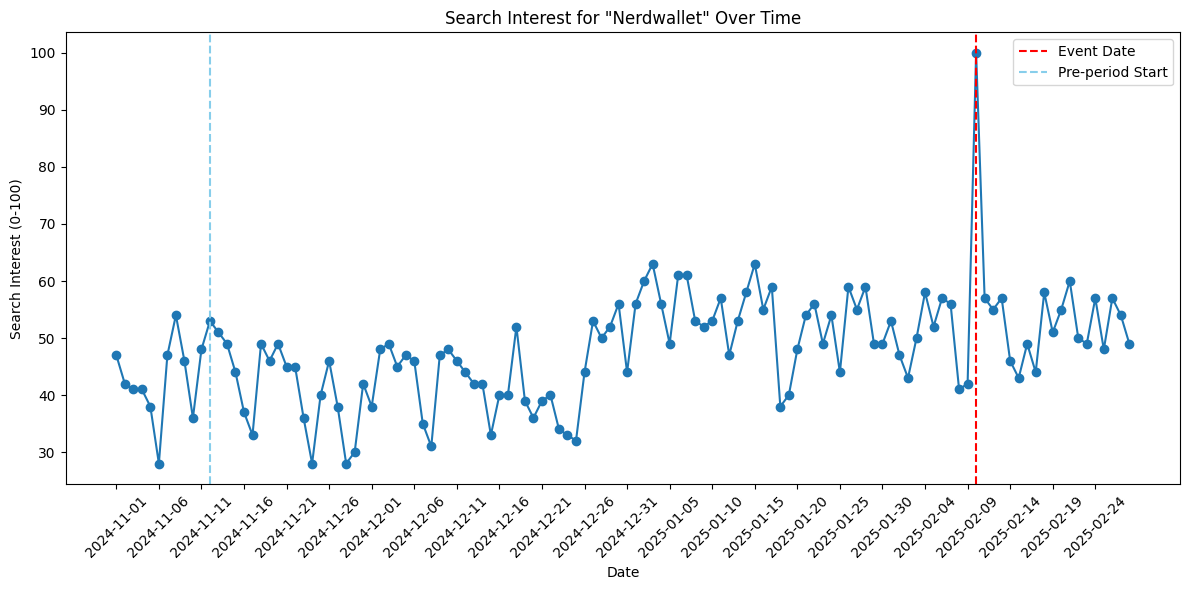

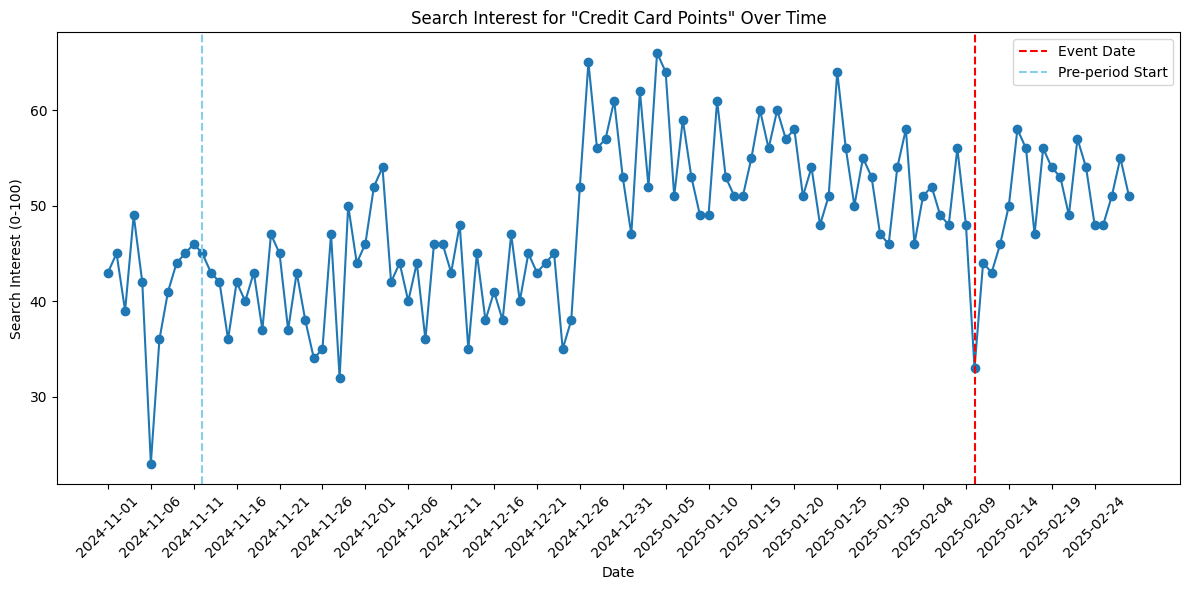

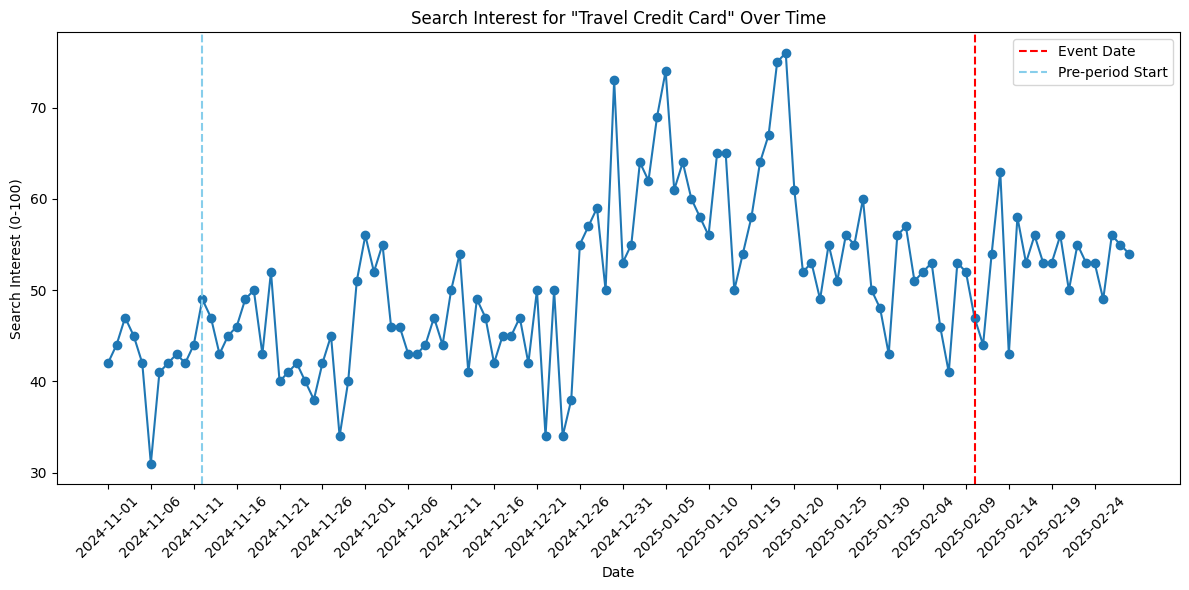

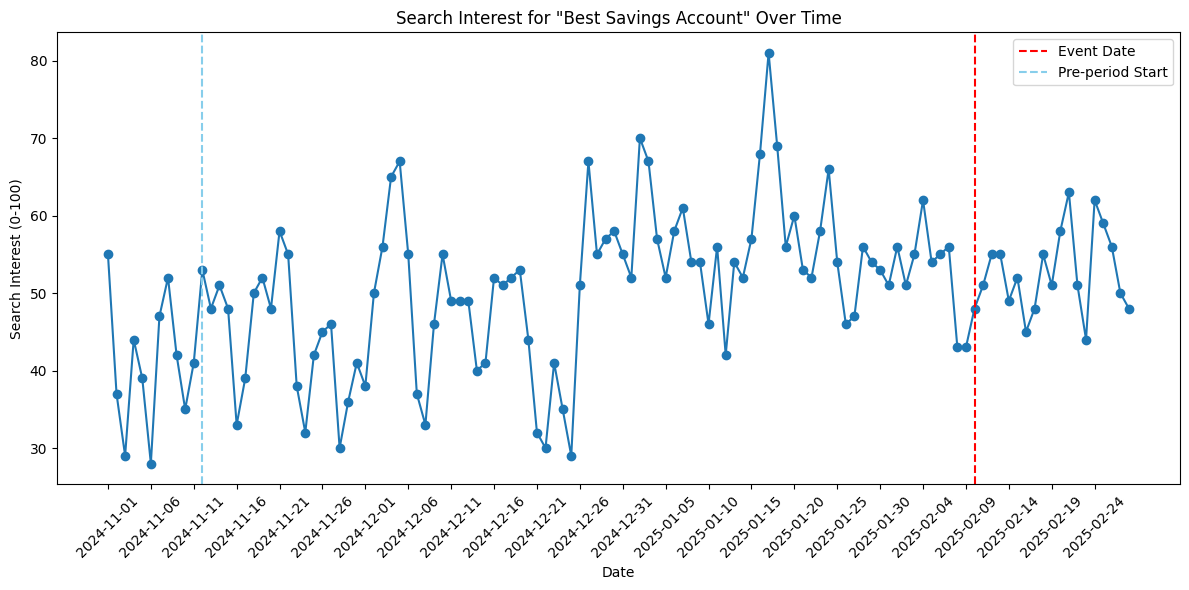

In [40]:
### nerdwallet timeseries plot
keyword_list = ['nerdwallet', 'credit_card_points', 'travel_credit_card', 'best_savings_account']
import matplotlib.pyplot as plt

for keyword in keyword_list:
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[keyword], marker='o', linestyle='-')
    plt.title(f'Search Interest for "{keyword.replace("_", " ").title()}" Over Time')
    plt.xlabel('Date')
    plt.ylabel('Search Interest (0-100)')
    xticks = df['date'][::5]
    plt.xticks(ticks=xticks, labels=xticks, rotation=45)
    # Plot vertical lines for event and pre-period start
    plt.axvline(x=event_date.strftime('%Y-%m-%d'), color='red', linestyle='--', label='Event Date')
    plt.axvline(x=start_date.strftime('%Y-%m-%d'), color='skyblue', linestyle='--', label='Pre-period Start')
    plt.legend()
    plt.tight_layout()
    plt.show()


## Interrupted Time Series (ITS) Modeling

In [41]:
# Fit an ITS model with level change only

# TO-DO: Create indicator for dates on or after treatment start 
event_date = pd.to_datetime(event_date)
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
df['date'] = pd.to_datetime(df['date'])
df['post_treatment_dummy'] = np.where(df['date']>event_date, 1, 0)
df['trend'] = (pd.to_datetime(df['date']) - event_date).dt.days

# TO-DO: Estimate an ITS model testing for a level change only 
subset_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

formula = 'nerdwallet ~ trend + post_treatment_dummy'  
its_model = smf.ols(formula = formula, data=subset_df).fit()
print(its_model.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     16.77
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           5.06e-07
Time:                        14:58:47   Log-Likelihood:                -373.16
No. Observations:                 105   AIC:                             752.3
Df Residuals:                     102   BIC:                             760.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               55.9128 

In [42]:
control = its_model.params['Intercept'] + subset_df['trend'] * its_model.params['trend']
treatment = its_model.params['Intercept'] + subset_df['trend'] * its_model.params['trend'] + subset_df['post_treatment_dummy'] * its_model.params['post_treatment_dummy']

Text(0, 0.5, 'Search Interest (0-100)')

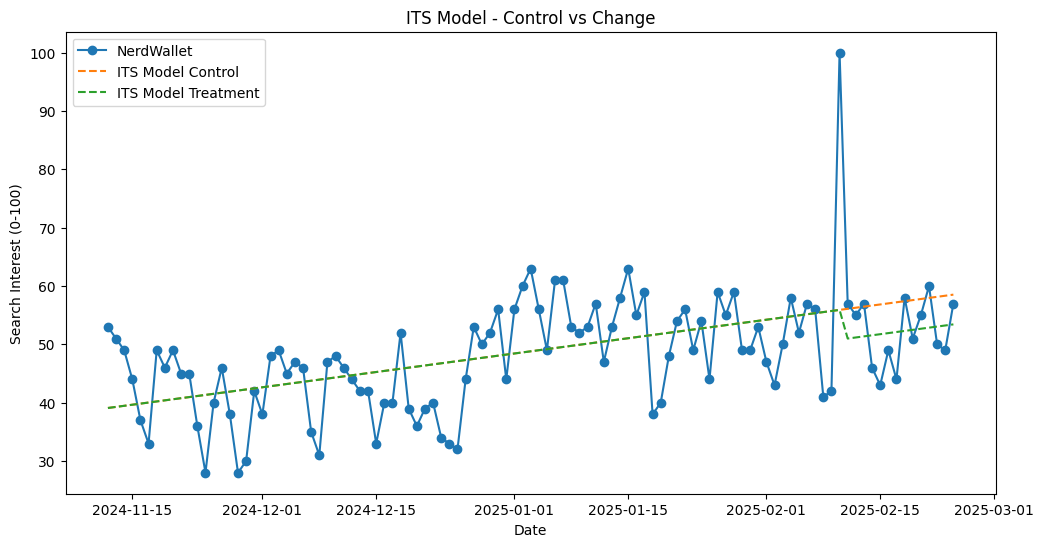

In [43]:
### plot the ITS model - control vs change
plt.figure(figsize=(12, 6))
plt.plot(subset_df['date'], subset_df['nerdwallet'], marker='o', linestyle='-', label='NerdWallet')
plt.plot(subset_df['date'], control, linestyle='--', label='ITS Model Control')
plt.plot(subset_df['date'], treatment, linestyle='--', label='ITS Model Treatment')
plt.title('ITS Model - Control vs Change')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Search Interest (0-100)')

## Difference-in-Differences (DiD) Modeling

In [64]:
df_long = df.melt(id_vars=['date'], value_vars=['nerdwallet', 'credit_card_points', 'travel_credit_card', 'best_savings_account'], var_name='keyword', value_name='search_interest')

In [46]:
df_long['trend'] = (pd.to_datetime(df_long['date']) - event_date).dt.days
df_long['post'] = np.where(df_long['date']>event_date, 1, 0)
df_long['treated'] = np.where(df_long['keyword'] == 'nerdwallet', 1, 0)

df_long_subset = df_long[(df_long['date'] >= start_date) & (df_long['date'] <= end_date)]

In [48]:
formula_did = 'search_interest ~ post + treated + post:treated'  
did_model = smf.ols(formula = formula_did, data=df_long_subset).fit()
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.499
Date:                Tue, 04 Nov 2025   Prob (F-statistic):             0.0156
Time:                        14:59:50   Log-Likelihood:                -1516.2
No. Observations:                 420   AIC:                             3040.
Df Residuals:                     416   BIC:                             3057.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       50.0549      0.544     92.010   

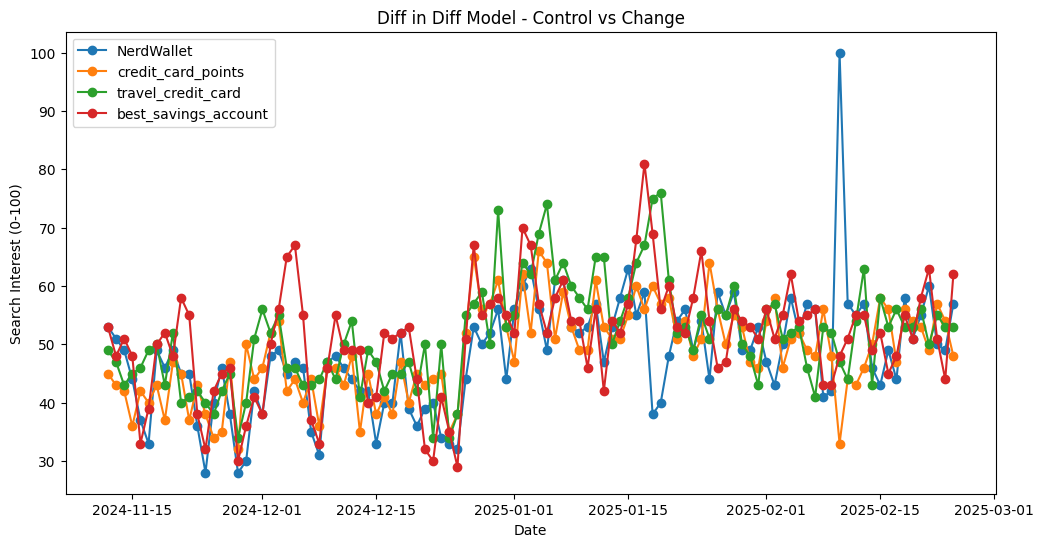

In [66]:
### plot the DiD model - control vs change  
plt.figure(figsize=(12, 6))

### plot the treated aka nerdwallet 
df_long_subset_treated = df_long_subset[df_long_subset['treated'] == 1]
plt.plot(df_long_subset_treated['date'], df_long_subset_treated['search_interest'], marker='o', label='NerdWallet')

### plot the controls, one by one
df_long_subset_controls = df_long_subset[df_long_subset['keyword'] != 'nerdwallet']
for keyword in df_long_subset_controls['keyword'].unique():
    df_long_subset_controls_keyword = df_long_subset_controls[df_long_subset_controls['keyword'] == keyword]
    plt.plot(df_long_subset_controls_keyword['date'], df_long_subset_controls_keyword['search_interest'], marker='o', label=keyword)

# plt.plot(subset_df['date'], control, linestyle='--', label='ITS Model Control')
# plt.plot(subset_df['date'], treatment, linestyle='--', label='ITS Model Treatment')
plt.title('Diff in Diff Model - Control vs Change')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Search Interest (0-100)')
plt.show()

In [67]:
df_long_subset['post_treated'] = df_long_subset['treated'] * df_long_subset['post']

In [68]:
did_effect = df_long_subset['post_treated'] * did_model.params['post:treated']
print(f"Avg daily Effect:{did_effect.sum()/df_long_subset['post_treated'].sum() : 0.1f}")

Avg daily Effect: 2.4


#### Diff in diff conclusion:
- Average treatment effect is an increase of 2.4 in terms of 'search score' for Nerdwallet, but this isn't stat sig comparing before to after

## Difference-in-Differences Modeling with Controls

In [71]:
df_long_subset['credit_card_points'] = np.where(df_long_subset['keyword'] == 'credit_card_points', 1, 0)
df_long_subset['travel_credit_card'] = np.where(df_long_subset['keyword'] == 'travel_credit_card', 1, 0)
df_long_subset['best_savings_account'] = np.where(df_long_subset['keyword'] == 'best_savings_account', 1, 0)

formula_did_w_controls = 'search_interest ~ post + treated + post*treated + credit_card_points + travel_credit_card + best_savings_account'  
did_model_w_controls = smf.ols(formula = formula_did_w_controls, data=df_long_subset).fit()
print(did_model_w_controls.summary())

                            OLS Regression Results                            
Dep. Variable:        search_interest   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     3.445
Date:                Tue, 04 Nov 2025   Prob (F-statistic):            0.00462
Time:                        15:15:30   Log-Likelihood:                -1512.9
No. Observations:                 420   AIC:                             3038.
Df Residuals:                     414   BIC:                             3062.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               39.5341 

## Event Study Modeling

In [74]:
event_study_formula = 'nerdwallet ~ credit_card_points + travel_credit_card + best_savings_account + post_treatment_dummy'
event_study_model = smf.ols(formula=event_study_formula, data=subset_df).fit()
print(event_study_model.summary())

                            OLS Regression Results                            
Dep. Variable:             nerdwallet   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     14.39
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           2.59e-09
Time:                        15:21:51   Log-Likelihood:                -364.22
No. Observations:                 105   AIC:                             738.4
Df Residuals:                     100   BIC:                             751.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               15.2438 

#### Event Study Modeling with Psuedo Model Permutations

In [128]:
preperiod_length = 60
postperiod_length = 7

days_that_can_be_shifted = (event_date - df['date'].min()).days - preperiod_length
print(days_that_can_be_shifted)

placebo_treatment_effects_list = []

for date_index in range(postperiod_length+1, days_that_can_be_shifted):
    event_date_placebo = event_date - pd.Timedelta(days=date_index)
    model_start_date_placebo = event_date_placebo - pd.Timedelta(days=preperiod_length)
    model_end_date_placebo = event_date_placebo + pd.Timedelta(days=postperiod_length)

    subset = df[(df['date']>=model_start_date_placebo) & (df['date']<model_end_date_placebo)]
    subset['post'] = np.where(subset['date']>=event_date_placebo, 1, 0)
    
    formula = 'nerdwallet ~ credit_card_points + travel_credit_card + best_savings_account + post'
    model = smf.ols(formula=formula, data=subset).fit()
    
    placebo_treatment_effects_list.append(model.params['post'])

41


/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/1291084437.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['post'] = np.where(subset['date']>=event_date_placebo, 1, 0)
/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/1291084437.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['post'] = np.where(subset['date']>=event_date_placebo, 1, 0)
/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/1291084437.py:15: SettingWithCopyWarning: 
A value is

In [129]:
print(f"Mean Placebo Effect: {np.mean(placebo_treatment_effects_list)}")

Mean Placebo Effect: 1.8754554032351354


In [130]:
rmse = (np.mean(np.square(placebo_treatment_effects_list)))**0.5
print(f"RMSE: {rmse}")

RMSE: 3.979495676883898


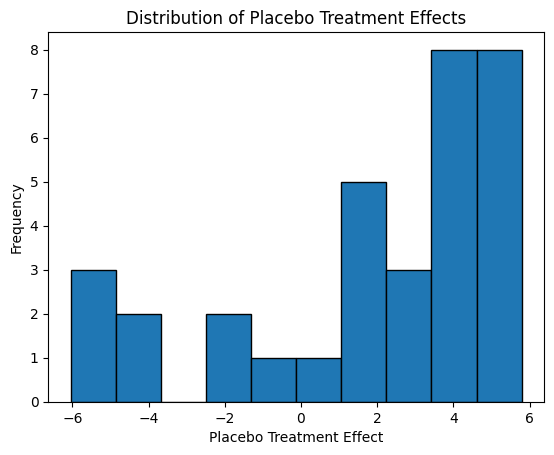

In [131]:
plt.hist(placebo_treatment_effects_list, bins=10, edgecolor='black')
plt.xlabel('Placebo Treatment Effect')
plt.ylabel('Frequency')
plt.title('Distribution of Placebo Treatment Effects')
plt.show()


## Estimating a Synthetic Control using Lasso

In [ ]:
treated_term = "nerdwallet"
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

preperiod = df[df['date']<event_date]

# Initialize Lasso model with a regularization parameter (in the future, you may want to tune this parameter)
lasso_model = LassoCV(cv=5, random_state=42)

# TO-DO: Fit the lasso model, save and print the coefficients
lasso_model.fit(preperiod[control_terms], preperiod[treated_term])
lasso_coefficients = lasso_model.coef_
lasso_intercept = lasso_model.intercept_
lasso_alpha = lasso_model.alpha_

print("Best alpha:", lasso_alpha)
print("Intercept:", lasso_intercept)
print("Coefficients:", lasso_coefficients)

Best alpha: 2.5048304995631097
Intercept: 12.70170660153029
Coefficients: [2.22961677e-01 1.87352687e-04 4.65674820e-01]


In [118]:
df["synthetic_control"] = df[control_terms].dot(lasso_coefficients) + lasso_intercept

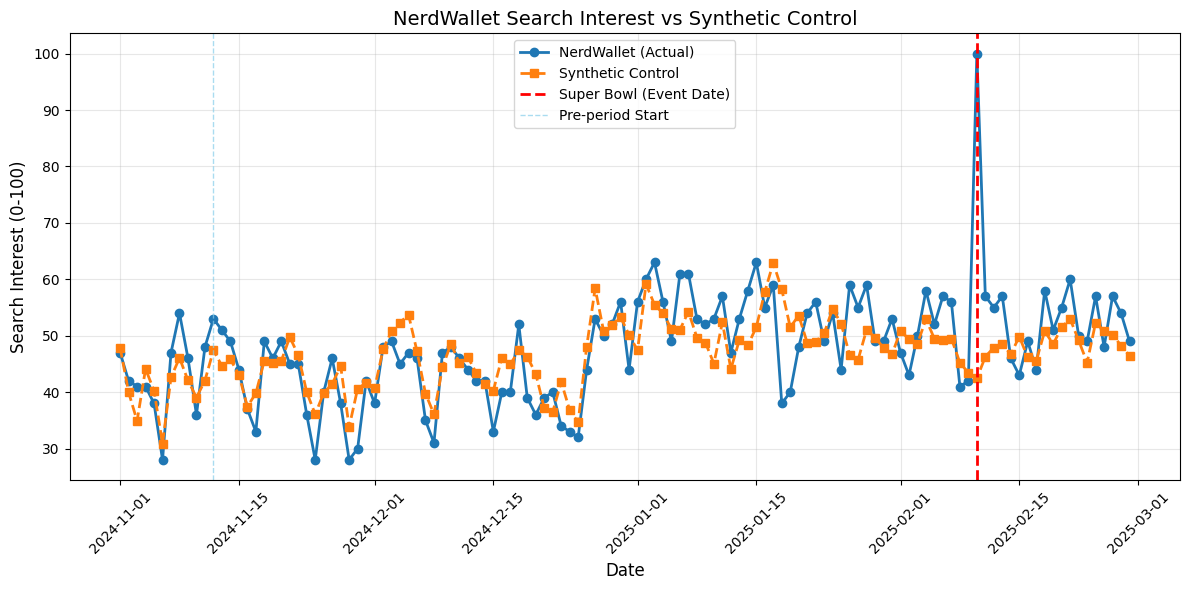

In [120]:
plt.figure(figsize=(12, 6))

# Plot actual NerdWallet data
plt.plot(df['date'], df['nerdwallet'], marker='o', linestyle='-', label='NerdWallet (Actual)', linewidth=2)

# Plot synthetic control
plt.plot(df['date'], df['synthetic_control'], marker='s', linestyle='--', label='Synthetic Control', linewidth=2)

# Add vertical line for event date
plt.axvline(x=event_date, color='red', linestyle='--', linewidth=2, label='Super Bowl (Event Date)')

# Add vertical line for pre-period start
plt.axvline(x=start_date, color='skyblue', linestyle='--', linewidth=1, alpha=0.7, label='Pre-period Start')

# Labels and formatting
plt.title('NerdWallet Search Interest vs Synthetic Control', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Search Interest (0-100)', fontsize=12)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

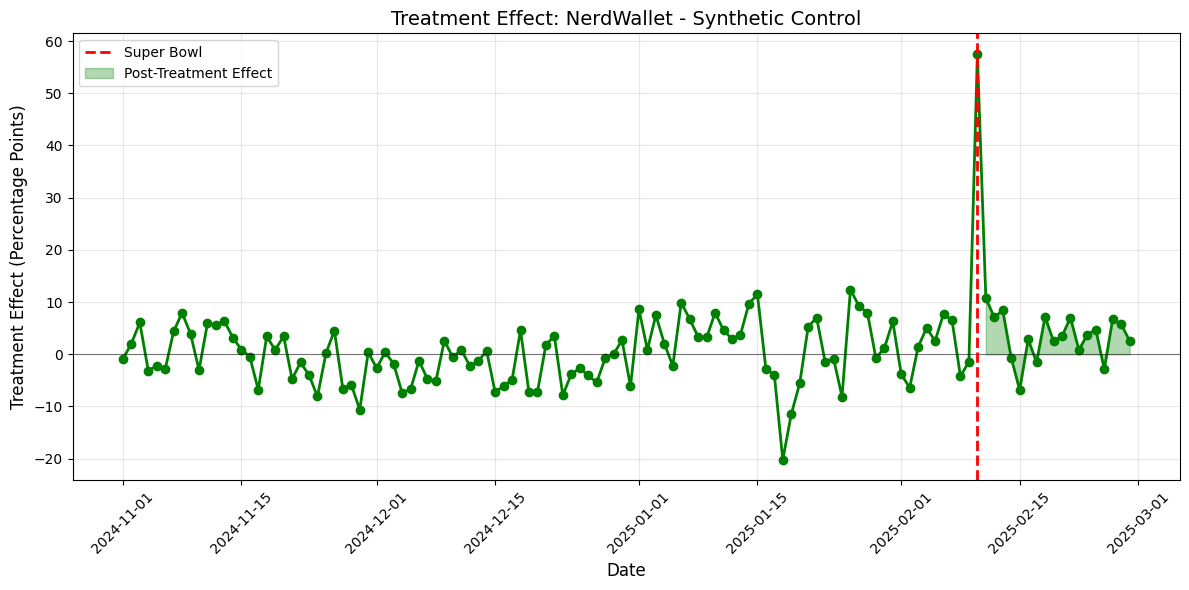

In [121]:
# Calculate the treatment effect (actual - synthetic)
df['treatment_effect'] = df['nerdwallet'] - df['synthetic_control']

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['treatment_effect'], marker='o', linestyle='-', linewidth=2, color='green')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
plt.axvline(x=event_date, color='red', linestyle='--', linewidth=2, label='Super Bowl')
plt.fill_between(df['date'], 0, df['treatment_effect'], 
                 where=(df['post_treatment_dummy']==1), 
                 alpha=0.3, color='green', label='Post-Treatment Effect')
plt.title('Treatment Effect: NerdWallet - Synthetic Control', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Treatment Effect (Percentage Points)', fontsize=12)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [123]:
# TO-DO: Calculate the average monthly treatment effect in the post-treatment period: 
# How does this compare to the value the treated region would have had without the intervention?  
post_period = df[df['date']>=event_date]
print('average monthly treatment effect in post-treatment period:', post_period["treatment_effect"].mean())

average monthly treatment effect in post-treatment period: 6.280104572429098


## Optimizing with Cross-Validation

In [155]:
from sklearn.preprocessing import StandardScaler

# 1. Define your control terms (donor pool)
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']

# 2. Filter to PRE-TREATMENT period only (this is crucial!)
pre_treatment_df = df[df['date'] < event_date].copy()

# 3. Prepare X (controls) and y (treated unit) for pre-treatment period
X_pre = pre_treatment_df[control_terms]
y_pre = pre_treatment_df['nerdwallet']

# 4. Standardize the features
scaler = StandardScaler()
X_pre_scaled = scaler.fit_transform(X_pre)

# 5. Use LassoCV to find optimal alpha with cross-validation
# - cv=5 means 5-fold cross-validation
# - alphas: list of alpha values to try (you can customize this)
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 2, 100),  # 100 alpha values from 0.0001 to 100
    cv=5,                             # 5-fold cross-validation
    random_state=42,
    max_iter=10000
)

# 6. Fit on pre-treatment data
lasso_cv.fit(X_pre_scaled, y_pre)

# 7. Get optimal alpha
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# 8. Get coefficients and intercept
lasso_coefficients = lasso_cv.coef_
lasso_intercept = lasso_cv.intercept_

print(f"\nSynthetic Control Weights:")
for term, coef in zip(control_terms, lasso_coefficients):
    print(f"  {term}: {coef:.4f}")

# 9. Create synthetic control for FULL period (pre + post)
X_full = df[control_terms]
X_full_scaled = scaler.transform(X_full)  # Use same scaler from pre-period
df['synthetic_control'] = lasso_cv.predict(X_full_scaled)




Optimal alpha: 0.32745491628777285

Synthetic Control Weights:
  credit_card_points: 1.8514
  travel_credit_card: 0.0000
  best_savings_account: 4.6488


## If necessary, net out pre-period differences using a Difference-in-Differences Model

#### Note: In some cases, the synthetic control may have a poor pre-period fit, or a different pre-treatment average outcome than the treated group. In those cases, you may wish to net out the pre-period differences using a DiD model.  If the pre-period fit is very close, then this step is not necessary; simply compare post-treatment outcomes. 

#### Important: The DiD model underestimates the standard error for synthetic control models and should NOT be used to determine statistical significance. The permutation tests below are for statistical significance and confidence intervals

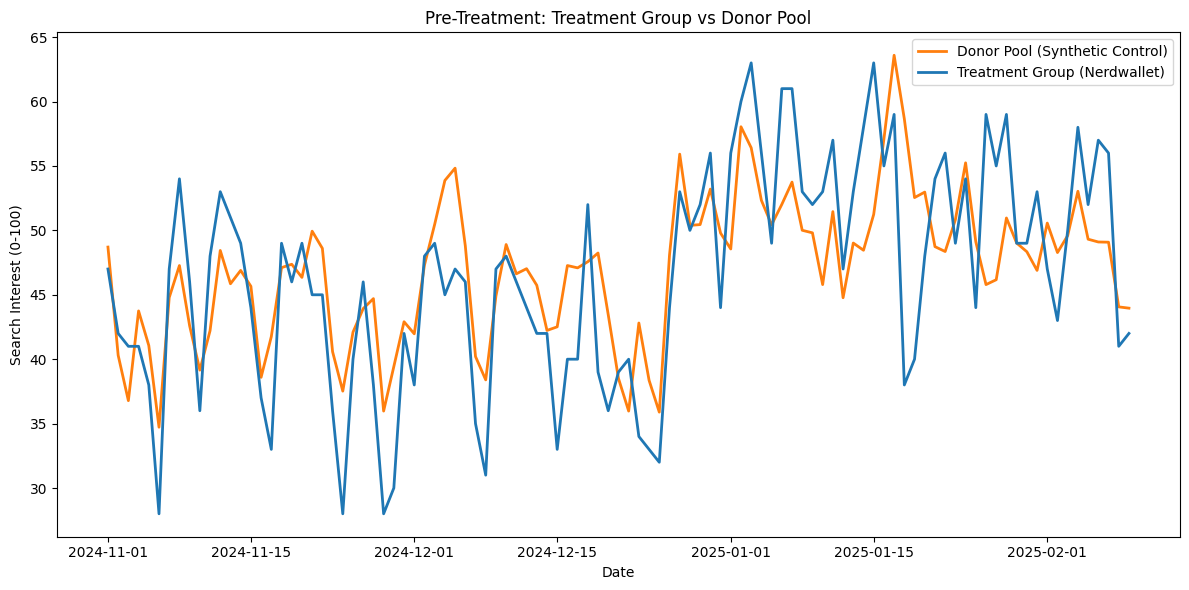

In [140]:
import matplotlib.pyplot as plt

# Plot donor pool (synthetic control) vs treatment group (Nerdwallet)
plt.figure(figsize=(12, 6))

# Plot donor pool: sum of weighted controls (the synthetic control)
plt.plot(pre_treatment_df['date'], pre_treatment_df['synthetic_control'], label='Donor Pool (Synthetic Control)', color='tab:orange', linewidth=2)

# Plot treatment group (Nerdwallet)
plt.plot(pre_treatment_df['date'], pre_treatment_df['nerdwallet'], label='Treatment Group (Nerdwallet)', color='tab:blue', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Search Interest (0-100)')
plt.title('Pre-Treatment: Treatment Group vs Donor Pool')
plt.legend()
plt.tight_layout()
plt.show()



In [156]:
# Check pre-treatment fit quality
pre_treatment_df_check = df[df['date'] < event_date]
mse_pre = np.mean((pre_treatment_df_check['nerdwallet'] - pre_treatment_df_check['synthetic_control'])**2)
print(f"\nPre-treatment MSE: {mse_pre:.2f}")

mae_pre = np.mean(np.abs(pre_treatment_df_check['nerdwallet'] - pre_treatment_df_check['synthetic_control']))
print(f"\nPre-treatment MAE: {mae_pre:.2f}")

pct_mae_of_avg = (mae_pre / pre_treatment_df_check['nerdwallet'].mean()) * 100
print(f"\nPre-treatment MAE as % of NerdWallet average: {pct_mae_of_avg:.2f}%")


Pre-treatment MSE: 31.88

Pre-treatment MAE: 4.58

Pre-treatment MAE as % of NerdWallet average: 9.87%


- conclusion: don't need DiD modeling with synthetic control, as the MSE / MAE is relatively small pre-treatment, meaning that the donor pool creates a pretty good pre-treatment fit of nerdwallet, signifying that it also makes a pretty good post-treatment proxy for what nerdwallet _wouldve_ looked like had it not gotten the super bowl ad

## Permutation Testing

#### Note: Obtaining confidence intervals for synthetic controls is a rapidly growing and changing field. At the time of this course, a common approach to determine statistical significance is via permutation testing.  

#### Whether you simply compared post-treatment outcomes or netted out pre-period differences using DiD, be consistent and run the same model structure for the permutation tests

### Geoff Notes:

- In-Space Placebos (Standard for Synthetic Control)

- This is what Abadie et al. (the original synthetic control authors) recommend:
- Concept: Pretend each control unit was treated instead, create synthetic controls for them, and see if their "fake" treatment effects are as large as your real one.

In [159]:
control_terms = ['credit_card_points', 'travel_credit_card', 'best_savings_account']
placebo_effects = []

all_units = ['nerdwallet'] + control_terms

pre_df = df[df['date'] < event_date]
post_df = df[df['date'] >= event_date]

for treated_unit in all_units:
    # Donor pool: all other units
    donor_pool = [u for u in all_units if u != treated_unit]
    
    X_pre = pre_df[donor_pool]
    y_pre = pre_df[treated_unit]
    
    scaler = StandardScaler()
    X_pre_scaled = scaler.fit_transform(X_pre)
    
    lasso_cv = LassoCV(
        alphas=np.logspace(-4, 2, 100),  # 100 alpha values from 0.0001 to 100
        cv=5,                             # 5-fold cross-validation
        random_state=42,
        max_iter=10000
    )
    lasso_cv.fit(X_pre_scaled, y_pre)
    
    # Predict on post-treatment data
    X_post = post_df[donor_pool]
    X_post_scaled = scaler.transform(X_post)
    post_df[f'synthetic_{treated_unit}'] = lasso_cv.predict(X_post_scaled)

    # Calculate treatment effect in post-period
    post_effect = (post_df[treated_unit] - post_df[f'synthetic_{treated_unit}']).mean()
    placebo_effects.append({
        'unit': treated_unit,
        'effect': post_effect,
        'is_treated': treated_unit == 'nerdwallet'
    })

# Create results dataframe
placebo_df = pd.DataFrame(placebo_effects)
print(placebo_df)

    
        

                   unit    effect  is_treated
0            nerdwallet  6.296673        True
1    credit_card_points -0.099553       False
2    travel_credit_card -0.002173       False
3  best_savings_account -3.448140       False


/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/1433471506.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_df[f'synthetic_{treated_unit}'] = lasso_cv.predict(X_post_scaled)
/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/1433471506.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_df[f'synthetic_{treated_unit}'] = lasso_cv.predict(X_post_scaled)
/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/1433471506.py:30: SettingWithCopyWarning: 
A va

/var/folders/tz/thmswyg57x1c4v09f7h_vlqw0000gn/T/ipykernel_50691/645371906.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  placebo_time_df['is_actual'] = placebo_time_df['is_actual'].fillna(False)


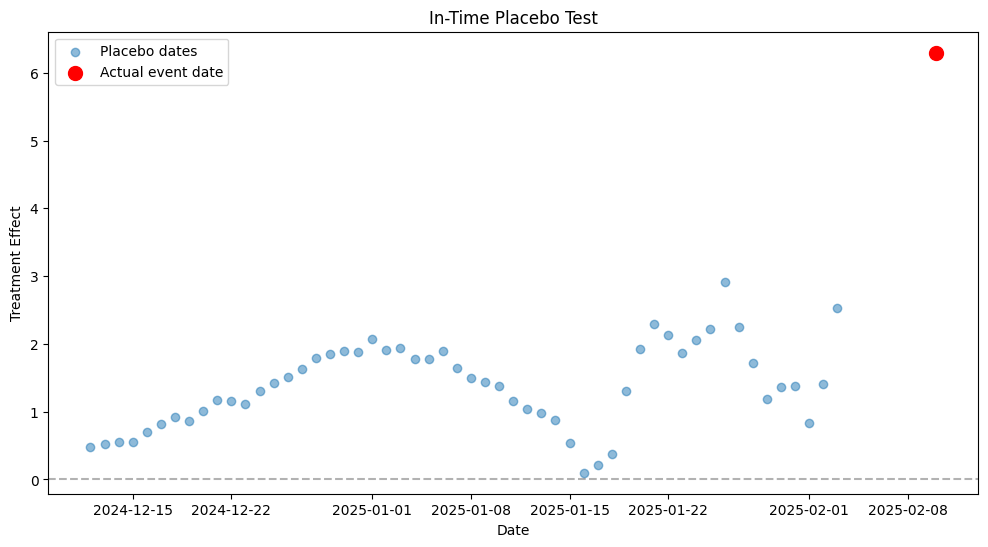

In [166]:
# In-time placebo test
placebo_dates = pd.date_range(
    start=start_date + pd.DateOffset(days=30),  # Start after some pre-period
    end=event_date - pd.DateOffset(days=7),      # End before real event
    freq='1D'  # Daily intervals
)

placebo_results = []

for placebo_date in placebo_dates:
    # Create temporary post indicator
    temp_post = ((df['date'] >= placebo_date) & (df['date'] < event_date)).astype(int)
    
    # Calculate "treatment effect" for this fake date
    post_placebo = df[temp_post == 1]
    placebo_effect = (post_placebo['nerdwallet'] - post_placebo['synthetic_control']).mean()
    
    placebo_results.append({
        'placebo_date': placebo_date,
        'effect': placebo_effect
    })

# Add actual effect
actual_post = df[df['date'] >= event_date]
actual_effect = (actual_post['nerdwallet'] - actual_post['synthetic_control']).mean()

placebo_results.append({
    'placebo_date': event_date,
    'effect': actual_effect,
    'is_actual': True
})

placebo_time_df = pd.DataFrame(placebo_results)
placebo_time_df['is_actual'] = placebo_time_df['is_actual'].fillna(False)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(placebo_time_df[~placebo_time_df['is_actual']]['placebo_date'], 
           placebo_time_df[~placebo_time_df['is_actual']]['effect'],
           alpha=0.5, label='Placebo dates')
plt.scatter(placebo_time_df[placebo_time_df['is_actual']]['placebo_date'],
           placebo_time_df[placebo_time_df['is_actual']]['effect'],
           color='red', s=100, label='Actual event date', zorder=5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Treatment Effect')
plt.title('In-Time Placebo Test')
plt.legend()
plt.show()

## Final Model Selection and Rationale

TODO: final model selection and rationale

## Sensitivity Tests:  

#### For your chosen final model, adjust at least one hyperparameter (such as pre-period window length) and ensure that the results aren't very sensitive to reasonable model choices

In [3]:
# TODO: Sensitivity Testing

## Key Takeaways for Stakeholders

#### The idea here: Imagine your stakeholders are comfortable with randomized experiments but not with observational causal inference.  What have you done so far in this project to help them feel comfortable that this is actually a reasonable causal estimate?

TODO: key takeaways for stakeholders